In [35]:
import os
import sys
module_path = os.path.abspath(os.path.join('../src'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from dataset.MultimodalityDataModule import MultimodalityDataModule
from pathlib import Path
from torch.nn.functional import softmax

import numpy as np

In [36]:
BASE_PATH = Path('/workspace/data')
DATA_PATH = BASE_PATH / 'multimodality_classification_with_micro.csv'
MAX_NUMBER_WORDS = 20000       # number of words to consider from embeddings vocabulary
MAX_WORDS_PER_SENTENCE = 300   # sentence maximum length
NUM_CLASSES = 4 
BASE_IMG_DIR = BASE_PATH       # the image path in the CSV file are relative to this directory
NUM_WORKERS = 72 

In [37]:
import pandas as pd
df = pd.read_csv(DATA_PATH, sep='\t')
df.head()

,Unnamed: 0,Unnamed: 0.1,ID,MODALITY,PATH,CAPTION,SET,SET_MICRO
0,0,201,1423-0127-16-7-1-1.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,VAL
1,1,202,1423-0127-16-7-1-2.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,TRAIN
2,2,203,1423-0127-16-7-1-4.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,TRAIN
3,3,204,1423-0127-16-7-1-5.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,VAL,TRAIN
4,4,205,1423-0127-16-7-1-6.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,TRAIN


In [38]:
dm = MultimodalityDataModule(32,
                             str(DATA_PATH),
                             MAX_NUMBER_WORDS,
                             MAX_WORDS_PER_SENTENCE,
                             str(BASE_IMG_DIR),
                             num_workers=NUM_WORKERS,
                             target_class_col='SET_MICRO')
dm.prepare_data()
dm.setup()

In [39]:
val_dataloader = dm.val_dataloader()

In [40]:
import torch, json
from experiments.microscopy.microscopy import experiment, get_model
vision_dict_path = '/workspace/src/experiments/microscopy/shallow-resnet152.json'
vision_model_id = 'resnet152.layer3-11'
vision_outputs_path = '/workspace/outputs'

with open(vision_dict_path) as json_file:
    vision_models = json.load(json_file)
vision_model_name, vision_experiment_name = vision_model_id.split('.')
vision_model = get_model(vision_model_name, "shallow", 4, layers=vision_models[vision_model_id]['layers'], pretrained=True)

checkpoint = torch.load(vision_outputs_path + '/{0}/checkpoint.pt'.format(vision_models[vision_model_id]['id']))
vision_model.load_state_dict(checkpoint)

<All keys matched successfully>

In [41]:
classes = val_dataloader.dataset.le.classes_
classes

array(['DMEL', 'DMFL', 'DMLI', 'DMTR'], dtype='<U4')

In [24]:
_, x, y = next(iter(val_dataloader))

In [55]:
vision_model.eval()

percentages = []
with torch.no_grad():    
    y_hat = vision_model(x)
    y_hat_softmax = softmax(y_hat, dim=1)
    
    max_percentages = torch.max(y_hat_softmax, dim=1).values
    percentages += max_percentages

In [60]:
percentages

[tensor(0.9900),
 tensor(0.9965),
 tensor(0.9942),
 tensor(0.9929),
 tensor(0.6316),
 tensor(0.9998),
 tensor(0.9932),
 tensor(0.3725),
 tensor(0.9943),
 tensor(0.9928),
 tensor(0.9973),
 tensor(0.9984),
 tensor(0.9986),
 tensor(0.9971),
 tensor(0.9439),
 tensor(0.9956),
 tensor(0.9970),
 tensor(0.9970),
 tensor(0.9935),
 tensor(0.9944),
 tensor(0.9764),
 tensor(0.9953),
 tensor(0.9980),
 tensor(0.9980),
 tensor(0.9974),
 tensor(0.9908),
 tensor(0.4086),
 tensor(0.9985),
 tensor(0.9848),
 tensor(0.9984),
 tensor(0.9971),
 tensor(0.9966)]

In [42]:
def acc_per_threshold(threshold, vis_model, dataloader):
    device = torch.device("cuda:0")
    percentages_under = []
    percentages_over = []
    out_y_preds_under = []
    out_y_preds_over = []
    out_y_trues_under = []
    out_y_trues_over = []
    text_seqs_under = []
    text_seqs_over = []

    model = vis_model.to(device)
    model.eval()

    with torch.no_grad():  
        for text_seq, x, y in dataloader:
            x = x.to(device)
            y = y.to(device)
            text_seq = text_seq.to(device)

            y_hat = model(x)
            y_hat_softmax = softmax(y_hat, dim=1)

            max_percentages, preds = torch.max(y_hat_softmax, dim=1)

            # threshold items
            masked_items  = max_percentages * (max_percentages > threshold)
            idx_under_thr = torch.where(masked_items==0)
            idx_over_thr  = torch.where(masked_items>0)

            y_preds_under_thr = preds[idx_under_thr]
            y_preds_over_thr  = preds[idx_over_thr]
            y_trues_under_thr = y[idx_under_thr]
            y_trues_over_thr  = y[idx_over_thr]
            text_seq_under_thr = text_seq[idx_under_thr]
            text_seq_over_thr = text_seq[idx_over_thr]
            percentages_under_thr = y_hat_softmax[idx_under_thr]
            percentages_over_thr = y_hat_softmax[idx_over_thr]
            
            percentages_under += percentages_under_thr.cpu()            
            percentages_over += percentages_over_thr.cpu()            
            
            out_y_preds_under += y_preds_under_thr.cpu()
            out_y_preds_over  += y_preds_over_thr.cpu()
            out_y_trues_under += y_trues_under_thr.cpu()
            out_y_trues_over  += y_trues_over_thr.cpu()
            text_seqs_under += text_seq_under_thr
            text_seqs_over += text_seq_over_thr
    
    return (percentages_under, percentages_over), (out_y_preds_under, out_y_preds_over), (out_y_trues_under, out_y_trues_over), (text_seqs_under, text_seqs_over)

In [43]:
def acc(y_trues, y_hats):
    if len(y_trues) == 0: return None
    y_preds = np.array(y_hats)
    y_trues = np.array(y_trues)
    return np.mean(y_preds == y_trues)

def report_acc(y_pred_under, y_pred_over, y_trues_under, y_trues_over):
    acc_under = acc(y_pred_under, y_trues_under)
    acc_over  = acc(y_pred_over, y_trues_over)
    acc_total = acc(y_pred_under + y_pred_over, y_trues_under + y_trues_over)
    return acc_under, acc_over, acc_total

In [44]:
threshold = 0.1
_, y_preds, y_trues, text_seqs = acc_per_threshold(threshold, vision_model, val_dataloader)

#report_acc(y_preds[0], y_preds[1], y_trues[0], y_trues[1])

In [77]:
len(text_seqs)

466

In [54]:
reverse_word_index = {}
for i in dm.word_index.keys():
    val = dm.word_index[i]
    reverse_word_index[val] = i

In [84]:
seq = text_seqs[0].squeeze()
text = []
for i in seq:
    if i > 0:
        text.append(reverse_word_index[i.item()])

In [87]:
' '.join(text)

'scanning electron microscope images of the tio 2 nanoparticles . a c150 b c200 c eds elemental spectrum of c200 d s. aureus and uv100 e s. aureus and c150 and f s. aureus and c200. scale bars 100 nm.'

In [177]:
acc_under_l = []
acc_over_l  = []
for threshold in np.arange(0.1, 1, 0.05):    
    _, y_preds, y_trues, _ = acc_per_threshold(threshold, vision_model, val_dataloader)
    acc_under, acc_over, _ = report_acc(y_preds[0], y_preds[1], y_trues[0], y_trues[1])
    print("{0:.2f}: {1}, {2}".format(threshold, acc_under, acc_over))
    acc_under_l.append(acc_under)
    acc_over_l.append(acc_over)

0.10: None, 0.9230769230769231
0.15: None, 0.9230769230769231
0.20: None, 0.9230769230769231
0.25: None, 0.9230769230769231
0.30: None, 0.9230769230769231
0.35: None, 0.9230769230769231
0.40: 0.0, 0.927038626609442
0.45: 0.2, 0.9308855291576674
0.50: 0.14285714285714285, 0.9349240780911063
0.55: 0.2222222222222222, 0.9368191721132898
0.60: 0.4, 0.9403973509933775
0.65: 0.42857142857142855, 0.9463087248322147
0.70: 0.46153846153846156, 0.9502262443438914
0.75: 0.45714285714285713, 0.9607390300230947
0.80: 0.47619047619047616, 0.9671361502347418
0.85: 0.5517241379310345, 0.975609756097561
0.90: 0.6197183098591549, 0.9773299748110831
0.95: 0.6981132075471698, 0.988950276243094


In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

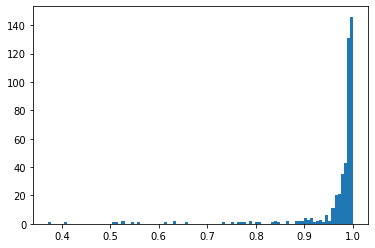

In [12]:
percentages = np.array(percentages)
plt.hist(percentages, bins=100);

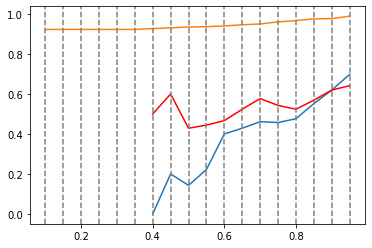

In [185]:
x = np.arange(0.1, 1, 0.05)
plt.plot(x, acc_under_l)
plt.plot(x, dumb_accs, color='red')
plt.plot(x, acc_over_l)
for i in x:
    plt.axvline(x=i, linestyle='--', color='gray')

In [151]:
threshold = 0.70
percentages, y_preds, y_trues, text_seqs = acc_per_threshold(threshold, vision_model, val_dataloader)

In [152]:
classes

array(['DMEL', 'DMFL', 'DMLI', 'DMTR'], dtype='<U4')

In [184]:
dumb_accs = []

for threshold in np.arange(0.1, 1, 0.05):
    percentages, y_preds, y_trues, text_seqs = acc_per_threshold(threshold, vision_model, val_dataloader)
    
    count_total = 0
    count_correct = 0
    for prob, y_pred, y_true, seq in zip(percentages[0], y_preds[0], y_trues[0], text_seqs[0]):
        y_dumb_hat = dumb_classifier(prob.cpu().numpy(), seq.squeeze().cpu().numpy(), reverse_word_index)
        if y_dumb_hat == y_true:
            count_correct += 1
            print(y_true)
        else:
            print("\x1b[31m\"{0}\"\x1b[0m".format(y_true))
        count_total += 1

    if count_total > 0:
        dumb_acc = count_correct/count_total
        dumb_accs.append(dumb_acc)
    else:
        dumb_accs.append(None)

************************************
gfp report valid unc 4 motor neuron gene a. unc 4 gfp express 13 embryon deriv motor neurons. color circl indic approxim locat unc 4 motor neuron soma newli hatch l1 larva. transgen anim express gfp report repres unc 4 motor neuron genes. anterior left. b. acr 14 confoc gfp dic projection. acr 14 gfp express rme head ventral nerv cord vnc motor neuron arrow c d. flp 13 confoc dic gfp imag head region. c match confoc gfp project note dd1 commissur dorsal side white arrow arrowhead mark nerv ring. e f. f29g6.2. arrow point vnc motor neuron l2 larva e posterior view vnc show f29g6.2 gfp express vnc motor neurons. asterisk mark gut autofluoresc f g h. tig 2 dic gfp imag l2 larva. note gfp express vnc motor neuron arrow head muscl arrowhead g confoc project anterior vnc. tig 2 gfp detect b class motor neuron pharyng muscl arrow bodi wall muscl bwm h scale bar 10 micron panel c f h 20 micron b e g
[0 1 0 0]
[1]
text same as vision: 1 [0.28091526 0.3725176

************************************
straw blood cell air solution. straw cell origin mous human animals. straw cell deriv mous epithelia lymphocyt liver lung cells. b human filament straw cell c human smooth straw cell pig lung straw cell e straw cell solut visibl dark dot diamet near 1 î¼ arrow f turnov straw cell incub 37 â° c vitro human blood rabbit sera g carton present straw cell components. h synchron rabbit straw cell air. straw cell lose filament extens incub steril water day 0. emerg new filament day 1. j emerg rabbit straw cell network 5 day dark arrow emerg aggreg cell bodi solut white arrow k emerg rabbit regular cell 6 day 12 day l 14 day space bar equal 10 î¼
[0 0 0 0]
text not useful: 3
"0"
************************************
gfp report valid unc 4 motor neuron gene a. unc 4 gfp express 13 embryon deriv motor neurons. color circl indic approxim locat unc 4 motor neuron soma newli hatch l1 larva. transgen anim express gfp report repres unc 4 motor neuron genes. anterio

************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 0
tensor(0)
************************************
spermatid individu control mer 3 e cysts. panel e illustr phase contrast view control mer 3 cyst respectively. panel b f show locat dapi stain sperm nuclei. panel c g display site arrowhead orient actin cone visual fitc conjug phalloidin staining. panel h repres merg images. panel enlarg view rectangular area denot panel f
[0 0 0 0]
text not useful: 1
"0"
************************************
straw blood cell air solution. straw cell origin mous human animals. straw cell deriv mous epithelia lymphocyt 

************************************
morpholog cd90 stain î¦ visual pappenheim stain electron microscopi b imag repres cell prepar least two differ donors. c comparison î¦ size forward scatter measur flow cytometry. light grey line im fill dark grey am. cd90 stain im. fill dark grey isotyp control light grey line antibodi staining. mfi valu given within graphs. data show one repres three independ experi cell obtain differ donor
[1 0 1 0]
[0]
text same as vision: 0 [0.6907487  0.07305136 0.17497718 0.0612228 ]
tensor(0)
************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 0
tensor(0)
******************

************************************
morpholog cd90 stain î¦ visual pappenheim stain electron microscopi b imag repres cell prepar least two differ donors. c comparison î¦ size forward scatter measur flow cytometry. light grey line im fill dark grey am. cd90 stain im. fill dark grey isotyp control light grey line antibodi staining. mfi valu given within graphs. data show one repres three independ experi cell obtain differ donor
[1 0 1 0]
[0]
text same as vision: 0 [0.6907487  0.07305136 0.17497718 0.0612228 ]
tensor(0)
************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 0
tensor(0)
******************

************************************
morpholog cd90 stain î¦ visual pappenheim stain electron microscopi b imag repres cell prepar least two differ donors. c comparison î¦ size forward scatter measur flow cytometry. light grey line im fill dark grey am. cd90 stain im. fill dark grey isotyp control light grey line antibodi staining. mfi valu given within graphs. data show one repres three independ experi cell obtain differ donor
[1 0 1 0]
[0]
text same as vision: 0 [0.6907487  0.07305136 0.17497718 0.0612228 ]
tensor(0)
************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 3
"0"
************************

************************************
morpholog cd90 stain î¦ visual pappenheim stain electron microscopi b imag repres cell prepar least two differ donors. c comparison î¦ size forward scatter measur flow cytometry. light grey line im fill dark grey am. cd90 stain im. fill dark grey isotyp control light grey line antibodi staining. mfi valu given within graphs. data show one repres three independ experi cell obtain differ donor
[1 0 1 0]
[0]
text same as vision: 0 [0.6907487  0.07305136 0.17497718 0.0612228 ]
tensor(0)
************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 3
"0"
************************

************************************
morpholog cd90 stain î¦ visual pappenheim stain electron microscopi b imag repres cell prepar least two differ donors. c comparison î¦ size forward scatter measur flow cytometry. light grey line im fill dark grey am. cd90 stain im. fill dark grey isotyp control light grey line antibodi staining. mfi valu given within graphs. data show one repres three independ experi cell obtain differ donor
[1 0 1 0]
[0]
text same as vision: 0 [0.6907487  0.07305136 0.17497718 0.0612228 ]
tensor(0)
************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 3
"0"
************************

************************************
morpholog cd90 stain î¦ visual pappenheim stain electron microscopi b imag repres cell prepar least two differ donors. c comparison î¦ size forward scatter measur flow cytometry. light grey line im fill dark grey am. cd90 stain im. fill dark grey isotyp control light grey line antibodi staining. mfi valu given within graphs. data show one repres three independ experi cell obtain differ donor
[1 0 1 0]
[0]
text same as vision: 0 [0.6907487  0.07305136 0.17497718 0.0612228 ]
tensor(0)
************************************
abnorm observ meiosi mer 3 spermatocyt spermatid contain two nuclei equal size arrow two nebenkern tripolar spindl spermatocyt go second meiotic divis b four polar spindl spermatocyt undergo second meiotic divis c e panel c show phase contrast imag panel dapi stain nuclei panel e merg image. arrow point central spindl midzon 29 comparison wild type meiotic cell telophas shown f
[0 0 0 0]
text not useful: 3
"0"
************************

tensor(2)
************************************
correl bex2 c jun express primari breast tumors. rel c jun express bex2 bex2 breast tumor use rt pcr. rr rel c jun express bex2 bex2 express differ bex2 express bex2 bex2 express bex2 sampl least 3 fold. error bar â± 2sem. b correl bex2 c jun gene expression. scatter plot demonstr correl ct valu bex2 c jun express use rt pcr breast tumors. correl coeffici 0.6 measur use pearson method. linear regress line best fit 95 confid interv line depict n 26 p 0.01 c bex2 protein level use immunohistochemistri ihc bex2 stain carri use ihc rabbit polyclon bex2 antibodi 1 50 dilution. percentag cell bex2 stain compar follow group previous defin rt pcr bex2 3 fold higher gene express median bex2 3 fold lower gene express median bex2 int. intermedi 3 fold gene express chang median. bex2 vs bex2 bex2 int. groups. error bar â± 2sem. bex2 stain ihc bex2 breast tumor 40 magnification. e correl bex2 c jun protein levels. scatter plot demonstr correl percentag

In [181]:
np.array([2,0,0,0])/np.linalg.norm(np.array([2,0,0,0]))

array([1., 0., 0., 0.])

In [55]:
def summary_item(idx):
    seq = text_seqs_under[idx].squeeze()
    text = []
    for i in seq:
        if i > 0:
            text.append(reverse_word_index[i.item()])
    print(' '.join(text))
    print('pred: ' + classes[y_preds[0][idx]])
    print('true: ' + classes[y_trues[0][idx]])
    print(percentages[0][idx])

In [56]:
summary_item(0)

gfp reporters validate unc 4 motor neuron genes . a. unc 4 gfp is expressed in 13 embryonically derived motor neurons. colored circles indicate approximate location of unc 4 motor neuron soma in newly hatched l1 larva. transgenic animals expressing gfp reporters for representative unc 4 motor neuron genes. anterior to left. b. acr 14 . confocal gfp dic projection. acr 14 gfp is expressed in rme in the head and in ventral nerve cord vnc motor neurons arrows . c d. flp 13 . confocal dic gfp image of head region. c and matched confocal gfp projection d . note dd1 commissure to dorsal side white arrow . arrowhead marks nerve ring. e f. f29g6.2. arrows point to vnc motor neurons l2 larva e . posterior view of vnc showing f29g6.2 gfp expression in all vnc motor neurons. asterisk marks gut autofluorescence f . g h. tig 2 . dic gfp image of l2 larva. note gfp expression in vnc motor neurons arrows and in head muscles arrowhead g . confocal projection of anterior vnc. tig 2 gfp is detected in a

In [65]:
import nltk

In [66]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import string

In [68]:
from nltk.tokenize.treebank import TreebankWordTokenizer, TreebankWordDetokenizer

In [69]:
seq = text_seqs_under[1].squeeze()
text = []
for i in seq:
    if i > 0:
        text.append(reverse_word_index[i.item()])
sentence = ' '.join(text)
sentence

'curcumin affects microtubule dynamics and mitotic spindle assembly . a. immunofluorescence for î² tubulin in daoy cells treated with dmso 0 î¼ m or curcumin 10 20 î¼ m for 6 hours. bar 20 î¼ m. b. analysis of mitotic spindle microtubules in daoy cells. mitotic cells were released from the g2 m arrest in the presence or absence of curcumin. the cells were fixed after 60 min of release and stained for î² tubulin red and dna blue . the arrow indicates segregation of chromosomes along the mitotic spindle while the arrowhead shows abnormal spindle formation and missegregation of chromosomes. bar 20 î¼ m. c. quantitative analysis of cells with abnormal mitotic spindles after 60 min of incubation with either vehicle or 20 î¼ m curcumin. error bars indicate standard deviations of three independent experiments.'

In [189]:
# ['DMEL', 'DMFL', 'DMLI', 'DMTR']
dumb_related_words = {
    0: ['electron', 'scanning', ' sem', ' stem', ' stm'],
    1: ['fluorescence', ' efic', 'insitu', 'reporter', 'histo'], # 'insitu', 'reporter', 'histo'
    2: ['light', 'insitu', 'insitu', 'reporter', 'histo'], # 'insitu', 'reporter', 'histo'
    3: ['transmission', ' tem'],
}

In [161]:
stemmer.stem(' scanning')

' scan'

In [159]:
rr = re.search(r'{0}'.format(stemmer.stem(' tem')), 'stem')
rr

In [76]:
import re

def count_related_words(caption_stem):
    count = [0, 0, 0, 0]
    for key in dumb_related_words.keys():
        for word in dumb_related_words[key]:
            found = 1 if re.search(r'{0}'.format(stemmer.stem(word)), caption_stem) else 0
            count[key] += found
    return np.array(count)

In [182]:
def dumb_classifier(vision_probs, caption_seqs, reverse_dictionary):
    max_vision = np.argmax(vision_probs)
    
    # go from sequence to text
    caption = []
    for i in caption_seqs:
        if i > 0: caption.append(reverse_word_index[i.item()])
            
    tokens = TreebankWordTokenizer().tokenize(' '.join(caption))    
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer()

    cleaned_caption = []
    for word in tokens:
        if (word not in stopwords_english and word not in string.punctuation):
            stem_word = stemmer.stem(word)
            cleaned_caption.append(stem_word)    
    
    cleaned_caption = ' '.join(cleaned_caption).lower()
    text_count = count_related_words(cleaned_caption)
    
    print("************************************")        
    print(cleaned_caption)
    print(text_count)    
        
    if np.sum(text_count) == 0:
        print("text not useful:", max_vision)
        return max_vision            
            
    text_mask = text_count > 0
    masked = vision_probs * text_mask
    max_idxs = np.argwhere(masked == np.amax(masked)).flatten()
    
    print(max_idxs)
    if max_vision in max_idxs:
        print("text same as vision:", max_vision, vision_probs)
        return max_vision
    else:
        normed_counts = text_count / np.linalg.norm(text_count)
        out = normed_counts * masked        
        print("masking with text:", np.argmax(out), vision_probs, out)
        return np.argmax(out)
    


In [102]:
vision_prediction = np.array([0.2912, 0.1834, 0.0509, 0.4745])
seq = text_seqs_under[0].squeeze()

dumb_classifier(vision_prediction, seq, reverse_word_index)

0

# Fix the validation and training set to match original microscopy values

In [7]:
import pandas as pd

In [10]:
df_multi = pd.read_csv('/workspace/data/multimodality_classification.csv', sep='\t')

In [11]:
df_multi.head()

,Unnamed: 0,ID,MODALITY,PATH,CAPTION,SET
0,201,1423-0127-16-7-1-1.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN
1,202,1423-0127-16-7-1-2.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN
2,203,1423-0127-16-7-1-4.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN
3,204,1423-0127-16-7-1-5.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,VAL
4,205,1423-0127-16-7-1-6.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN


In [12]:
df_micro = pd.read_csv("/workspace/labels/microscopy.csv")

In [13]:
df_micro.head()

,ID,NAME,MODALITY,SET,PATH
0,1,1471-2180-10-125-2-1.jpg,DMEL,train,/mnt/train/DMEL/1471-2180-10-125-2-1.jpg
1,2,1423-0127-16-7-1-2.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-2.jpg
2,3,1471-2180-10-125-2-2.jpg,DMEL,train,/mnt/train/DMEL/1471-2180-10-125-2-2.jpg
3,4,1423-0127-16-7-1-4.jpg,DMEL,train,/mnt/train/DMEL/1423-0127-16-7-1-4.jpg
4,5,1471-2180-10-125-2-6.jpg,DMEL,train,/mnt/train/DMEL/1471-2180-10-125-2-6.jpg


In [164]:
df_micro[df_micro['NAME']=='1423-0127-16-7-1-1.jpg']['SET'].values[0]

'validation'

In [32]:
def rename_set(name):
    if name == 'validation': return 'VAL'
    return name.upper()

df_multi['SET_MICRO'] = df_multi.apply(lambda x: rename_set(df_micro[df_micro['NAME']==x['ID']]['SET'].values[0]), axis=1)

In [33]:
df_multi.head()

,Unnamed: 0,ID,MODALITY,PATH,CAPTION,SET,SET_MICRO
0,201,1423-0127-16-7-1-1.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,VAL
1,202,1423-0127-16-7-1-2.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,TRAIN
2,203,1423-0127-16-7-1-4.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,TRAIN
3,204,1423-0127-16-7-1-5.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,VAL,TRAIN
4,205,1423-0127-16-7-1-6.jpg,DMEL,subfigure-classification/2016/train/DMEL/1423-...,Scanning electron microscope images of the TiO...,TRAIN,TRAIN


In [34]:
df_multi.to_csv('/workspace/data/multimodality_classification_with_micro.csv', sep='\t')

In [168]:
test_dataloader = dm.test_dataloader()

In [190]:
acc_under_l = []
acc_over_l  = []
for threshold in np.arange(0.1, 1, 0.05):    
    _, y_preds, y_trues, _ = acc_per_threshold(threshold, vision_model, test_dataloader)
    acc_under, acc_over, _ = report_acc(y_preds[0], y_preds[1], y_trues[0], y_trues[1])
    print("{0:.2f}: {1}, {2}".format(threshold, acc_under, acc_over))
    acc_under_l.append(acc_under)
    acc_over_l.append(acc_over)

0.10: None, 0.8991981672394044
0.15: None, 0.8991981672394044
0.20: None, 0.8991981672394044
0.25: None, 0.8991981672394044
0.30: None, 0.8991981672394044
0.35: 1.0, 0.8990825688073395
0.40: 1.0, 0.8990825688073395
0.45: 0.6666666666666666, 0.9032634032634033
0.50: 0.5909090909090909, 0.9071680376028202
0.55: 0.6060606060606061, 0.9107142857142857
0.60: 0.5789473684210527, 0.9137724550898204
0.65: 0.5384615384615384, 0.9220462850182704
0.70: 0.5652173913043478, 0.927860696517413
0.75: 0.5714285714285714, 0.9340937896070975
0.80: 0.59, 0.9391979301423027
0.85: 0.626984126984127, 0.9451137884872824
0.90: 0.6882352941176471, 0.9502133712660028
0.95: 0.7546468401486989, 0.9635761589403974


In [191]:
dumb_accs = []

for threshold in np.arange(0.1, 1, 0.05):
    percentages, y_preds, y_trues, text_seqs = acc_per_threshold(threshold, vision_model, test_dataloader)
    
    count_total = 0
    count_correct = 0
    for prob, y_pred, y_true, seq in zip(percentages[0], y_preds[0], y_trues[0], text_seqs[0]):
        y_dumb_hat = dumb_classifier(prob.cpu().numpy(), seq.squeeze().cpu().numpy(), reverse_word_index)
        if y_dumb_hat == y_true:
            count_correct += 1
            print(y_true)
        else:
            print("\x1b[31m\"{0}\"\x1b[0m".format(y_true))
        count_total += 1

    if count_total > 0:
        dumb_acc = count_correct/count_total
        dumb_accs.append(dumb_acc)
    else:
        dumb_accs.append(None)

************************************
c. normal pattern neurogenesi cell progress cell phase column 0 cell 90 cyclin b column 3 5. arrowhead indic column 0 f. ectop neurogenesi occur second mitot wave arrow 100 cell cyclin b genotyp 11 g i. p21 prevent entri cell contain cyclin b posterior 10 ectop neurogenesi still delay column 5 howev arrow
[0 0 0 0]
text not useful: 0
tensor(0)
************************************
c. normal pattern neurogenesi cell progress cell phase column 0 cell 90 cyclin b column 3 5. arrowhead indic column 0 f. ectop neurogenesi occur second mitot wave arrow 100 cell cyclin b genotyp 11 g i. p21 prevent entri cell contain cyclin b posterior 10 ectop neurogenesi still delay column 5 howev arrow
[0 0 0 0]
text not useful: 0
tensor(0)
************************************
format intercellular connect network format observ among dio label green label msc red 24 hour co culture. b stain red reveal activ mitochondria network yellow arrow c time pictur format dio label 

************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel b averag 8 differ experi control 4 differ experi p 0.05 p 0.01 compar control. panel c arrow head indic cell dna damag arrow indic cell undergo apoptosi typic like tail small head
[0 0 0 0]
text not useful: 1
tensor(1)
************************************
format intercellular connect network format observ among dio label green label msc red 24 hour co culture. b stain red reveal activ mitochondria network yellow arrow c time pictur format dio label green label stem cell red
[1 0 0 0]
[0]
masking with text: 0 [0.41464075 0.4577707  0.10552724 0.02206123] [0.41464075 0.         0.         0.        ]
ten

************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel b averag 8 differ experi control 4 differ experi p 0.05 p 0.01 compar control. panel c arrow head indic cell dna damag arrow indic cell undergo apoptosi typic like tail small head
[0 0 0 0]
text not useful: 1
tensor(1)
************************************
format intercellular connect network format observ among dio label green label msc red 24 hour co culture. b stain red reveal activ mitochondria network yellow arrow c time pictur format dio label green label stem cell red
[1 0 0 0]
[0]
masking with text: 0 [0.41464075 0.4577707  0.10552724 0.02206123] [0.41464075 0.         0.         0.        ]
ten

************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel b averag 8 differ experi control 4 differ experi p 0.05 p 0.01 compar control. panel c arrow head indic cell dna damag arrow indic cell undergo apoptosi typic like tail small head
[0 0 0 0]
text not useful: 1
tensor(1)
************************************
format intercellular connect network format observ among dio label green label msc red 24 hour co culture. b stain red reveal activ mitochondria network yellow arrow c time pictur format dio label green label stem cell red
[1 0 0 0]
[0]
masking with text: 0 [0.41464075 0.4577707  0.10552724 0.02206123] [0.41464075 0.         0.         0.        ]
ten

************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel b averag 8 differ experi control 4 differ experi p 0.05 p 0.01 compar control. panel c arrow head indic cell dna damag arrow indic cell undergo apoptosi typic like tail small head
[0 0 0 0]
text not useful: 1
tensor(1)
************************************
format intercellular connect network format observ among dio label green label msc red 24 hour co culture. b stain red reveal activ mitochondria network yellow arrow c time pictur format dio label green label stem cell red
[1 0 0 0]
[0]
masking with text: 0 [0.41464075 0.4577707  0.10552724 0.02206123] [0.41464075 0.         0.         0.        ]
ten

************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel b averag 8 differ experi control 4 differ experi p 0.05 p 0.01 compar control. panel c arrow head indic cell dna damag arrow indic cell undergo apoptosi typic like tail small head
[0 0 0 0]
text not useful: 1
tensor(1)
************************************
format intercellular connect network format observ among dio label green label msc red 24 hour co culture. b stain red reveal activ mitochondria network yellow arrow c time pictur format dio label green label stem cell red
[1 0 0 0]
[0]
masking with text: 0 [0.21209301 0.6781234  0.09129761 0.01848592] [0.21209301 0.         0.         0.        ]
ten

************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel b averag 8 differ experi control 4 differ experi p 0.05 p 0.01 compar control. panel c arrow head indic cell dna damag arrow indic cell undergo apoptosi typic like tail small head
[0 0 0 0]
text not useful: 1
tensor(1)
************************************
effect cigarett smoke human bronchial epitheli cell dna damag surviv human bronchial epitheli cell expos 10 cigarett smoke extract 24 hour 0.5 î¼ 4 hour respect medium. attach cell harvest combin use tunel assay panel dna content cell analysi panel b assay panel c coloni format assay panel data present panel c one repres experi least 4 2b cells. panel

************************************
7 rh dextran 2 7 1 dose respons dextran 2 7 1 vulva error bar two independ inject 50 embryo inject worm randomli pick score vulva reach adults. b exampl imag show vulva
[0 0 0 0]
text not useful: 3
"0"
************************************
orthogon polar imag vascular structur small object 5
[0 0 0 0]
text not useful: 3
tensor(3)
************************************
clinic imag arrow b radiograph arrow c sagitt t1 weight mri show project high signal intens arrow cap low signal intens fine arrow connect tissu includ matrix intermedi signal intens dot arrow histopatholog imag bone cover fibrou cartilag stain origin magnif 40
[0 1 1 0]
[1]
masking with text: 1 [0.22997108 0.28336942 0.05326193 0.4333976 ] [0.         0.20037244 0.03766187 0.        ]
"3"
************************************
enhanc msc surviv vector modif inhibit complet percentag determin assay exposur p 0.05 msc vs. non transduc msc b dapi stain msc 72 h c percentag apoptot nuclei per 

************************************
microscop studi isol salt gland top view c side view f isol salt glands. note increas degre imag present left right confoc microscop imag show morpholog detail isol salt glands. sc secretori cell st stalk cell collect bar 5 î¼
[0 0 0 0]
text not useful: 2
tensor(2)
************************************
microscop studi isol salt gland top view c side view f isol salt glands. note increas degre imag present left right confoc microscop imag show morpholog detail isol salt glands. sc secretori cell st stalk cell collect bar 5 î¼
[0 0 0 0]
text not useful: 2
"1"
************************************
perfus cross section imag peripher imag control femor head. bar 500 î¼ m. b peripher imag necrot femor head. bar 500 î¼ m. c intern imag control femor head. bar 100 î¼ m. intern imag necrot femor head. bar 100 î¼
[0 0 0 0]
text not useful: 2
tensor(2)
************************************
perfus cross section imag peripher imag control femor head. bar 500 î¼ m. 

************************************
transmiss electron micrograph show leaf chloroplast mitochondri ultrastructur arabidopsi grown three sampl taken elev b e f elev ii c note larger a. thaliana grown elev ii. addit mitochondria elev ii st grain mi mitochondrion bar 1 î¼ f
[1 0 0 1]
[3]
text same as vision: 3 [0.18963508 0.0168476  0.0252685  0.7682488 ]
tensor(3)
************************************
independ signal might liver could partli stem like cell downstream protein level independ significantli increas plc 5 sphere compar parent cell line. gapdh use load control. b 10 î¼ could reduc activ downstream compon independ signal consequ c secondari plc 5 form cell treat 10 î¼ dmso control 7 days. format abil treat group significantli inhibit comparison dmso treat control
[1 0 0 0]
[0]
masking with text: 0 [0.03997498 0.20713899 0.7193374  0.0335486 ] [0.03997498 0.         0.         0.        ]
"2"
************************************
control case roi bone. b spectrum correspond long

************************************
confoc imag 5 ht 2a receptor hippocampu control experiment rat use immunofluoresc 5 ht 2a receptor specif primari antibodi fitc secondari antibodi pixel intens pixel intens control â± â± â± c â± b â± c â± c â± c valu mean â± s.e.m 4 6 rat group. group consist 6 8 rats. p 0.001 compar control group b p 0.05 c p 0.001 compar group. signific revers 5 ht 2a receptor near control level treatment alon combin therapi compar rats. arrow white show 5 ht 2a receptor
[0 1 0 0]
[1]
text same as vision: 1 [0.0297082  0.8695806  0.06136294 0.03934822]
tensor(1)
************************************
epitheli delet î² enhanc cell apoptosi real time quantit pcr show lung caspas 3 express indic embryon postnat b tunel stain quantif tunel posit nuclei bar repres fold induct doubl transgen compar control lung data express mean â± sem p 0.05
[1 0 0 0]
[0]
masking with text: 0 [0.02453317 0.8682895  0.08339173 0.02378567] [0.02453317 0.         0.         0.        ]
"1"


************************************
patholog exhibit stain pattern primari motor cortex 2 26 month old ad mice coron mous brain section 30 î¼ prepar ad mice sacrif 2 q 3 b j r 6 c k 9 l 12 e u 15 f n v 18 g w 26 month age h p x process immunohistochemistri detect human mutant transgen use monoclon antibodi h human phospho use monoclon antibodi p pair helic filament patholog use 1 monoclon antibodi q x primari motor cortex examin pattern immunoposit photomicrograph obtain 10 inset panel h p x repres 40 digit magnifi imag photomicrograph better visual immunoposit cell scale bar repres 200 î¼
[0 1 1 0]
[2]
masking with text: 2 [0.36738947 0.03953802 0.17248307 0.42058945] [0.         0.0279576  0.12196395 0.        ]
"3"
************************************
patholog exhibit stain pattern primari motor cortex 2 26 month old ad mice coron mous brain section 30 î¼ prepar ad mice sacrif 2 q 3 b j r 6 c k 9 l 12 e u 15 f n v 18 g w 26 month age h p x process immunohistochemistri detect human 

************************************
confoc imag 5 ht 2a receptor hippocampu control experiment rat use immunofluoresc 5 ht 2a receptor specif primari antibodi fitc secondari antibodi pixel intens pixel intens control â± â± â± c â± b â± c â± c â± c valu mean â± s.e.m 4 6 rat group. group consist 6 8 rats. p 0.001 compar control group b p 0.05 c p 0.001 compar group. signific revers 5 ht 2a receptor near control level treatment alon combin therapi compar rats. arrow white show 5 ht 2a receptor
[0 1 0 0]
[1]
text same as vision: 1 [0.0297082  0.8695806  0.06136294 0.03934822]
tensor(1)
************************************
reduc ir induc infarct size lv repres mid myocardi stain heart ir dark blue area zone area white area tissu red area viabl b lv similar ir groups. significantli myocardi lv compar ir n 10 p 0.05 compar ir group
[0 0 0 0]
text not useful: 2
tensor(2)
************************************
epitheli delet î² enhanc cell apoptosi real time quantit pcr show lung caspas 3 expre

************************************
e local yolk sac tissu tie2cr srf f f embryo photomicrograph wild type c 400 mutant b 2 000 yolk sac tissu stain red e green immunofluoresc analysi reveal decreas detect e protein mutant samples. e stain observ endoderm ed mesoderm md layer wild type yolk sac contrast littl e stain detect yolk sac tie2cr srf f f embryo b singl plane confoc microscopi c 4 000 confirm lack e immunostain apic border surfac mutant yolk sac endoderm cell compar b arrowhead blue stain b dapi nuclear stain. scale bar b 50 î¼ c î¼
[0 1 0 0]
[1]
text same as vision: 1 [0.02734744 0.8754466  0.07622469 0.02098125]
tensor(1)
************************************
human esc deriv neuroectoderm precursor neural b neural tube like structur c neural neural tube like structur found te 06 deriv eb cultur laminin neural columnar cell co express green nestin red b c cultur fed anoth 3 day neural tube like structur scale bar b 50 î¼ c 100 î¼
[0 0 0 0]
text not useful: 3
tensor(3)
*******

************************************
immunohistochem detect cytosol c tissu differ stage day 16 19 21 c detect use polyclon antibodi dilut 1 100 follow incub anti goat antibodi 1 500 reaction dab presenc h 2 2 arrow indic cytoplasm immunostain c cells. tissu section contain cell c giant cell vesicular cell v group c control rat correspond imag b c 16 th 19 th 21 st day respect w tumour bear rat correspond imag e f 16 th 19 th 21 st day respect rat inject ascit fluid correspond imag g h 16 th 19 th 21 st day respectively. imag j neg control. magnif 40 horizont bar 10 î¼
[0 1 1 0]
[2]
text same as vision: 2 [0.01322868 0.01386595 0.8999919  0.07291351]
tensor(2)
************************************
immunohistochem detect cytosol c tissu differ stage day 16 19 21 c detect use polyclon antibodi dilut 1 100 follow incub anti goat antibodi 1 500 reaction dab presenc h 2 2 arrow indic cytoplasm immunostain c cells. tissu section contain cell c giant cell vesicular cell v group c control rat c

************************************
photomicrograph illustr coron section primari visual cortex macaqu monkey brain nissl stain section show pattern cortic layer vi neuron region. b stain plasma one age 6 note panel figur 2e highest number label neuron locat superfici layer iii c section area demonstr situ hybrid probe acid 67 brown reaction illustr neuron similar represent gabaerg neuron identifi monoclon antibodi î³ acid e stain similar shown figur 2b plasma anoth age 5 f section area react plasma typic develop age 5 light background stain distribut nissl stain cell bodi specif label gabaerg neurons. calibr bar 100 î¼
[0 0 1 0]
[2]
text same as vision: 2 [0.01587019 0.04646914 0.926201   0.01145969]
tensor(2)
************************************
photomicrograph illustr coron section primari visual cortex macaqu monkey brain nissl stain section show pattern cortic layer vi neuron region. b stain plasma one age 6 note panel figur 2e highest number label neuron locat superfici layer ii

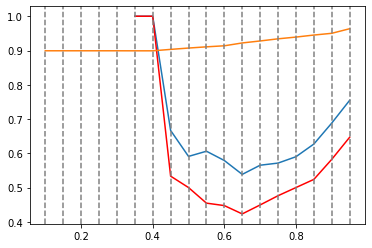

In [192]:
x = np.arange(0.1, 1, 0.05)
plt.plot(x, acc_under_l)
plt.plot(x, dumb_accs, color='red')
plt.plot(x, acc_over_l)
for i in x:
    plt.axvline(x=i, linestyle='--', color='gray')